# Web scraping with Selenium
  * [Selenium documentation](https://www.selenium.dev/documentation/)

## 0. Requirements

### 0.1. Download the web driver of your choice
* [Chrome](https://chromedriver.chromium.org/downloads)
* [Edge](https://developer.microsoft.com/en-us/microsoft-edge/tools/webdriver/#downloads)

Make sure the version you download matches the version of your browser

e.g.
```bash
edge://version/
```

### 0.2. Install the necessary libraries

```bash
conda env create -f environment.yml
```

In [1]:
import pandas as pd
import numpy as np
import datetime
import re

from selenium import webdriver
from selenium.webdriver.edge.options import Options as EdgeOptions
from selenium.webdriver.edge.service import Service
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.wait import WebDriverWait

from IPython.display import display, Image

## 1. Start web driver

In [2]:
options = EdgeOptions()
options.add_argument('window-size=1200x600')

service = Service('./edgedriver_win64/msedgedriver.exe')

driver = webdriver.Edge(options=options, service=service)

Navigate to page and reject all cookies

In [3]:
driver.get('https://www.oddsportal.com/soccer/england/premier-league/')

# wait for cookies popup to load, then reject all cookies
try:
    reject_cookies_button = WebDriverWait(driver, timeout=5).until(EC.presence_of_element_located((By.ID, 'onetrust-reject-all-handler')))
    reject_cookies_button.click()
except TimeoutException:
    print('Cookies popup not found')

Get `tournamentTable` element

In [4]:
table = driver.find_element(By.ID, 'tournamentTable')
table_rows = table.find_elements(By.TAG_NAME, 'tr')
# remove header and dummy rows
table_rows = [r.text for r in table_rows if r.text != '' and not ('»') in r.text]
table_rows

["Today, 08 Feb 1 X 2 B's",
 '19:45\n Newcastle - Everton\n2.59\n3.39\n2.86\n14',
 '19:45\n West Ham - Watford\n1.47\n4.72\n7.20\n14',
 '20:00\n Burnley - Manchester Utd\n5.93\n4.08\n1.62\n14',
 "Tomorrow, 09 Feb 1 X 2 B's",
 '19:45\n Manchester City - Brentford\n1.12\n9.95\n24.46\n14',
 '19:45\n Norwich - Crystal Palace\n3.56\n3.39\n2.19\n14',
 '19:45\n Tottenham - Southampton\n1.62\n4.17\n5.75\n14',
 '20:00\n Aston Villa - Leeds\n1.81\n4.00\n4.37\n14',
 "10 Feb 2022 1 X 2 B's",
 '19:45\n Liverpool - Leicester\n1.27\n6.65\n10.71\n14',
 '19:45\n Wolves - Arsenal\n3.63\n3.28\n2.22\n14',
 "12 Feb 2022 1 X 2 B's",
 '12:30\n Manchester Utd - Southampton\n1.57\n4.41\n5.82\n12',
 '15:00\n Brentford - Crystal Palace\n2.66\n3.14\n2.91\n12',
 '15:00\n Everton - Leeds\n2.15\n3.77\n3.25\n13',
 '15:00\n Watford - Brighton\n3.65\n3.31\n2.16\n12',
 '17:30\n Norwich - Manchester City\n17.41\n7.84\n1.17\n13',
 "13 Feb 2022 1 X 2 B's",
 '14:00\n Burnley - Liverpool\n9.16\n5.27\n1.35\n13',
 '14:00\n New

In [5]:
# split list up by dates
date_idx = []
idx = 0

# get all rows with dates and store their index
for row in table_rows:
    if "1 X 2 B's" in row:
        date_idx.append(idx)
    idx += 1

print('Rows with dates are: ', date_idx)

Rows with dates are:  [0, 4, 9, 12, 18]


In [6]:
# schema of dataframe
df = {
    'Date': [],
    'Home Team': [],
    'Away Team': [],
    'Home Odds': [],
    'Draw Odds': [],
    'Away Odds': [],
    'Bookmakers Surveyed': []
}

# for each separate date
for d, i in zip(date_idx, range(len(date_idx))):
    
    # extract date
    date = table_rows[d]
    date = date.replace(" 1 X 2 B's", '')
    date = date.replace(' ', '-')
    
    # remove unnecessary text
    if 'Tomorrow' in date or 'Today' in date:
        date = date[date.find(',')+2: ] + ' ' + str(datetime.datetime.now().year)
    
    # first match is the row after the date header
    first_match = date_idx[i]+1

    fixtures = []
    
    # get all matches between this date and the next date
    if i < len(date_idx)-1:
        last_match = date_idx[i+1]
        fixtures = table_rows[first_match:last_match]
    
    # if last date, get all matches after this date
    else:
        fixtures = table_rows[first_match:]
    
    # add each row to dictionary
    for f in fixtures:

        # split row into columns
        f = f.split('\n')

        # if "BetLive Streaming" icon in row, it adds extra \n character
        if len(f) > 5:
            f = [f[0] + f[1], f[2], f[3], f[4], f[5]]
        
        # extract date
        kick_off = f[0].split()[0]
        # home team is text after kick off, before dash
        home_team = re.search(r'[0-2][0-9]:[0-6][0-9](.*?)-', f[0]).group(1).strip()
        # away team after dash
        away_team = f[0].partition(' - ')[-1].strip()

        # convert odds to probabilities
        total_odds = float(f[1]) + float(f[2]) + float(f[3])
        home_prob = float(f[3]) / total_odds
        draw_prob = float(f[2]) / total_odds
        away_prob = float(f[1]) / total_odds
        
        df['Date'].append(pd.to_datetime(f'{date} {kick_off}'))
        df['Home Team'].append(home_team)
        df['Away Team'].append(away_team)
        df['Home Odds'].append(home_prob)
        df['Draw Odds'].append(draw_prob)
        df['Away Odds'].append(away_prob)
        df['Bookmakers Surveyed'].append(f[-1])

# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(10)

,Date,Home Team,Away Team,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,2022-02-08 19:45:00,Newcastle,Everton,0.323529,0.383484,0.292986,14
1,2022-02-08 19:45:00,West Ham,Watford,0.537715,0.352502,0.109783,14
2,2022-02-08 20:00:00,Burnley,Manchester Utd,0.139295,0.350817,0.509888,14
3,2022-02-09 19:45:00,Manchester City,Brentford,0.688432,0.280045,0.031523,14
4,2022-02-09 19:45:00,Norwich,Crystal Palace,0.239606,0.370897,0.389497,14
5,2022-02-09 19:45:00,Tottenham,Southampton,0.498267,0.361352,0.140381,14
6,2022-02-09 20:00:00,Aston Villa,Leeds,0.429273,0.392927,0.177800,14
7,2022-02-10 19:45:00,Liverpool,Leicester,0.574879,0.356951,0.068170,14
8,2022-02-10 19:45:00,Wolves,Arsenal,0.243154,0.359255,0.397590,14
9,2022-02-12 12:30:00,Manchester Utd,Southampton,0.493220,0.373729,0.133051,12


## Headless mode

In [7]:
options.add_argument('headless')
options.add_argument('window-size=1200x600')

service = Service('./edgedriver_win64/msedgedriver.exe')

driver = webdriver.Edge(options=options, service=service)

We can take a peek at what the webdriver sees using the `get_screenshot_as_png()` method on the driver object.

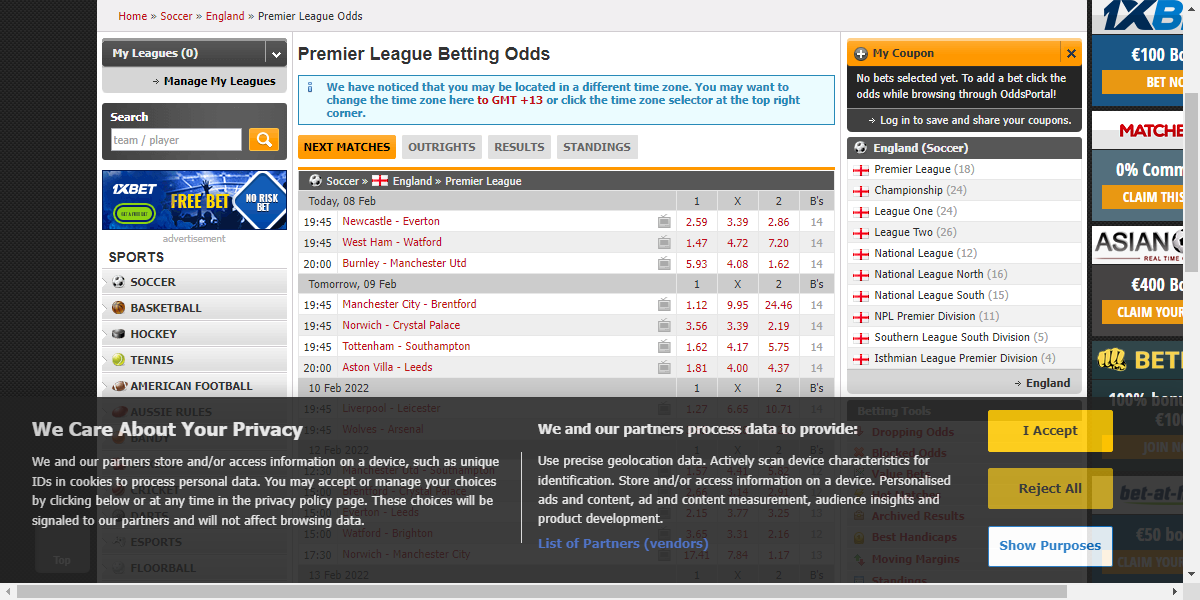

In [8]:
driver.get('https://www.oddsportal.com/soccer/england/premier-league/')

# wait for cookies popup to load, then reject all cookies
try:
    reject_cookies_button = WebDriverWait(driver, timeout=5).until(EC.presence_of_element_located((By.ID, 'onetrust-reject-all-handler')))
    reject_cookies_button.click()
    clicked = WebDriverWait(driver, timeout=5).until(EC.invisibility_of_element_located((By.ID, 'onetrust-accept-all-handler')))
    driver.implicitly_wait(5)
except TimeoutException:
    print('Cookies popup not found')

# scroll down a bit
driver.execute_script("window.scrollTo(0, 250)")

# show what driver sees
display(
    Image(
        driver.get_screenshot_as_png(),
        width=1200,
        height=800
    )
)